In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv, find_dotenv
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

load data

In [2]:
df = pd.read_csv('../data/FIFA22_official_data.csv', sep=',', encoding='utf-8')
columns_to_drop_when_loading_data = ['Photo','Club Logo', 'Real Face', 'Flag']
df = df.drop(columns=columns_to_drop_when_loading_data)


In [3]:
df.columns

Index(['ID', 'Name', 'Age', 'Nationality', 'Overall', 'Potential', 'Club',
       'Value', 'Wage', 'Special', 'Preferred Foot',
       'International Reputation', 'Weak Foot', 'Skill Moves', 'Work Rate',
       'Body Type', 'Position', 'Jersey Number', 'Joined', 'Loaned From',
       'Contract Valid Until', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'Best Position',
       'Best Overall Rating', 'Release Clause', 'DefensiveAwareness'],
      dtype='object')

Create several data frames

In [4]:
df_cleaned = df.copy()
# data frame containing information about the player
df_players = df[['ID','Name', 'Age','Overall', 'Position', 'Nationality', 'Club', 'Wage','Value']]


# data frame used for unsupervised learning
# dropping for now the 'Value'
columns_to_drop = ['Name', 'Age', 'Nationality', 'Potential', 'Club', 'Special', 'Release Clause','Best Overall Rating','Value','Joined','Jersey Number','Loaned From', 'Contract Valid Until','Marking',
                   'Best Position']
df_cleaned = df.drop(columns=columns_to_drop)

Clean Wage and Preferred Foot column

In [5]:
# Clean Wage: Remove K and €
df_cleaned ['Wage']= df_cleaned['Wage'].apply(lambda x: x.replace('K', '000') if 'K' in str(x) else x)
df_cleaned['Wage'] = df_cleaned['Wage'].apply(lambda x: x.replace('€', '') if '€' in str(x) else x)

# Clean Height and Weight
df_cleaned ['Height']= df_cleaned['Height'].apply(lambda x: x.replace('cm', '') if 'cm' in str(x) else x)
df_cleaned['Weight'] = df_cleaned['Weight'].apply(lambda x: x.replace('kg', '') if 'kg' in str(x) else x)

# Hot encode preffered foot
df_encoded = pd.get_dummies(df_cleaned['Preferred Foot'], prefix='Preferred Foot')
df_encoded['Preferred Foot_Left'] = df_encoded['Preferred Foot_Left'].astype(int)
df_encoded['Preferred Foot_Right'] = df_encoded['Preferred Foot_Right'].astype(int)
df_cleaned = pd.concat([df_cleaned, df_encoded], axis=1)
df_cleaned = df_cleaned.drop(columns=['Preferred Foot'])


Clean Work Rate column

In [6]:
# print(df_cleaned['Work Rate'])
split_values = pd.DataFrame()
split_values[['Work Rate Offense', 'Work Rate Defense', 'a', 'b']] = df_cleaned['Work Rate'].str.split('/', expand=True)
mapping = {'Low': 1, 'Medium': 2, 'High' : 3}

split_values['Work Rate Offense'] = split_values['Work Rate Offense'].map(mapping)

split_values['Work Rate Defense'] = split_values['Work Rate Defense'].apply(lambda x: x.replace(' ', '') if ' ' in str(x) else x)
split_values['Work Rate Defense'] = split_values['Work Rate Defense'].map(mapping)
split_values[['Work Rate Offense', 'Work Rate Defense']] = split_values[['Work Rate Offense', 'Work Rate Defense']].fillna('0')

split_values['Work Rate Offense'] = split_values['Work Rate Offense'].astype(int)
split_values['Work Rate Defense'] = split_values['Work Rate Defense'].astype(int)
split_values = split_values[['Work Rate Offense','Work Rate Defense']]
# split_values[['off', 'dev']]

df_cleaned = pd.concat([df_cleaned, split_values], axis=1)
df_cleaned = df_cleaned.drop(columns=['Work Rate'])

Clean Body Type column

In [7]:
df_cleaned['Body Type'] = df_cleaned['Body Type'].str.replace(r'\s*\(.*\)', '', regex=True)
df_encoded = pd.get_dummies(df_cleaned['Body Type'], prefix='Body Type')
df_encoded['Body Type_Lean'] = df_encoded['Body Type_Lean'].astype(int)
df_encoded['Body Type_Normal'] = df_encoded['Body Type_Normal'].astype(int)
df_encoded['Body Type_Stocky'] = df_encoded['Body Type_Lean'].astype(int)
df_encoded['Body Type_Unique'] = df_encoded['Body Type_Normal'].astype(int)

df_cleaned = pd.concat([df_cleaned, df_encoded], axis=1)
df_cleaned = df_cleaned.drop(columns=['Body Type'])

Clean Position column

In [8]:
def clean_position(string):
    html_string = '<span class="pos pos16">LM'

    # Define a regular expression pattern to match HTML tags
    html_tags_pattern = re.compile(r'<.*?>')

    # Use the sub() function to replace matched HTML tags with an empty string
    cleaned_string = html_tags_pattern.sub('', str(string))
    return cleaned_string

df_cleaned['Position'] = df_cleaned['Position'].apply(clean_position)
df_players['Position'] =  df_cleaned['Position'].apply(clean_position)
df_players.to_csv('../data/player_data.csv', sep=',')
df_players

C:\Users\Alexander Lorenz\AppData\Local\Temp\ipykernel_25480\3202435813.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_players['Position'] =  df_cleaned['Position'].apply(clean_position)


,ID,Name,Age,Overall,Position,Nationality,Club,Wage,Value
0,212198,Bruno Fernandes,26,88,CAM,Portugal,Manchester United,€250K,€107.5M
1,209658,L. Goretzka,26,87,LDM,Germany,FC Bayern München,€140K,€93M
2,176580,L. Suárez,34,88,RS,Uruguay,Atlético de Madrid,€135K,€44.5M
3,192985,K. De Bruyne,30,91,RCM,Belgium,Manchester City,€350K,€125.5M
4,224334,M. Acuña,29,84,LB,Argentina,Sevilla FC,€45K,€37M
...,...,...,...,...,...,...,...,...,...
16705,240558,18 L. Clayton,17,53,RES,England,Cheltenham Town,€1K,€100K
16706,262846,�. Dobre,20,53,RES,Romania,FC Academica Clinceni,€550,€180K
16707,241317,21 Xue Qinghao,19,47,RES,China PR,Shanghai Shenhua FC,€700,€100K
16708,259646,A. Shaikh,18,47,SUB,India,ATK Mohun Bagan FC,€500,€110K


In [9]:
df_cleaned['Position'].unique()
offense = ['RS','LS','RW','LW','ST','CF','LF','RF']
midfield = ['CAM','LDM','RCM','RDM','LCM','RM','LM','CDM','CM','RAM','LAM']
defense = ['RCB','CB','LWB','LCB','LB','RB','RWB']
goalkeeper = ['GK']
outlier = ['nan','RES', 'SUB']

combined_list = offense + midfield + defense + goalkeeper + outlier

Create global position encoding

In [10]:
def assign_category(pos):
    if pos in offense:
        return 'offense'
    elif pos in midfield:
        return 'midfield'
    elif pos in defense:
        return 'defense'
    elif pos in goalkeeper:
        return 'goalkeeper'
    elif pos in outlier:
        return 'outlier'
    else:
        return 'unknown'

# Apply the function to create the 'new pos' column
df_cleaned['Global Position'] = df_cleaned['Position'].apply(assign_category)

df_encoded = pd.get_dummies(df_cleaned['Global Position'], prefix='Global Position')
df_encoded['Global Position_defense'] = df_encoded['Global Position_defense'].astype(int)
df_encoded['Global Position_goalkeeper'] = df_encoded['Global Position_goalkeeper'].astype(int)
df_encoded['Global Position_midfield'] = df_encoded['Global Position_midfield'].astype(int)
df_encoded['Global Position_offense'] = df_encoded['Global Position_offense'].astype(int)
df_encoded['Global Position_outlier'] = df_encoded['Global Position_outlier'].astype(int)


df_cleaned = pd.concat([df_cleaned, df_encoded], axis=1)
df_cleaned = df_cleaned.drop(columns=['Global Position'])

In [11]:
df_encoded = pd.get_dummies(df_cleaned['Position'], prefix='Position')
df_encoded = df_encoded.astype(int)
df_cleaned = pd.concat([df_cleaned, df_encoded], axis=1)
df_cleaned = df_cleaned.drop(columns=['Position'])

In [12]:
df_cleaned.shape, df_cleaned.columns

((16710, 85),
 Index(['ID', 'Overall', 'Wage', 'International Reputation', 'Weak Foot',
        'Skill Moves', 'Height', 'Weight', 'Crossing', 'Finishing',
        'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
        'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
        'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
        'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
        'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
        'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
        'GKKicking', 'GKPositioning', 'GKReflexes', 'DefensiveAwareness',
        'Preferred Foot_Left', 'Preferred Foot_Right', 'Work Rate Offense',
        'Work Rate Defense', 'Body Type_Lean', 'Body Type_Normal',
        'Body Type_Stocky', 'Body Type_Unique', 'Global Position_defense',
        'Global Position_goalkeeper', 'Global Position_midfield',
        'Global Position_offense', 'Global Position_outli

There are missing values and also columns containing no values. There are dropped at this point.

In [13]:
# identifying missing values 
missing_values_per_column = df_cleaned.isna().sum()
columns_with_missing_values = missing_values_per_column[missing_values_per_column > 0]
#print(columns_with_missing_values)

# drop all entries with missing values
df_cleaned = df_cleaned.dropna(axis=0)

df = df_cleaned.copy()


The cleaning of of columns is done. Now inspect distributions and normalize the data.


In [14]:
df.columns

Index(['ID', 'Overall', 'Wage', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'DefensiveAwareness',
       'Preferred Foot_Left', 'Preferred Foot_Right', 'Work Rate Offense',
       'Work Rate Defense', 'Body Type_Lean', 'Body Type_Normal',
       'Body Type_Stocky', 'Body Type_Unique', 'Global Position_defense',
       'Global Position_goalkeeper', 'Global Position_midfield',
       'Global Position_offense', 'Global Position_outlier', 'Position_CAM',
       

Normalize

In [15]:
df_normalized = df.copy()

# apply log to wage
df_normalized['Wage'] = np.log(df_normalized['Wage'].astype(int) + 1)


# define columns to normalize
columns_to_normalize = ['Overall', 'Height', 'Weight', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes', 'DefensiveAwareness']


# Standardize values
scaler = StandardScaler()

df_normalized[columns_to_normalize] = scaler.fit_transform(df_cleaned[columns_to_normalize])

df = df_normalized.copy()
display(df)

,ID,Overall,Wage,International Reputation,Weak Foot,Skill Moves,Height,Weight,Crossing,Finishing,...,Position_RDM,Position_RES,Position_RF,Position_RM,Position_RS,Position_RW,Position_RWB,Position_ST,Position_SUB,Position_nan
0,212198,3.197778,12.429220,3.0,3.0,4.0,-0.353843,-0.869188,1.977395,1.774061,...,0,0,0,0,0,0,0,0,0,0
1,209658,3.041584,11.849405,4.0,4.0,3.0,1.098401,0.949142,1.299699,1.722503,...,0,0,0,0,0,0,0,0,0,0
2,176580,3.197778,11.813037,5.0,4.0,3.0,0.081830,1.089013,1.582072,2.289645,...,0,0,0,0,1,0,0,0,0,0
3,192985,3.666359,12.765691,4.0,5.0,4.0,-0.063395,-0.729316,2.372717,1.722503,...,0,0,0,0,0,0,0,0,0,0
4,224334,2.573002,10.714440,2.0,3.0,4.0,-1.370415,-0.869188,1.977395,0.897570,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16703,259718,-2.425202,6.478510,1.0,3.0,1.0,0.953177,1.089013,-2.201730,-2.041253,...,0,1,0,0,0,0,0,0,0,0
16704,251433,-1.488038,6.857514,1.0,2.0,1.0,1.969748,1.368756,-2.484103,-2.041253,...,0,1,0,0,0,0,0,0,0,0
16706,262846,-2.269008,6.311735,1.0,2.0,1.0,1.824523,1.508628,-2.201730,-2.144370,...,0,1,0,0,0,0,0,0,0,0
16707,241317,-3.206171,6.552508,1.0,2.0,1.0,-0.208619,-0.589445,-2.258204,-2.041253,...,0,1,0,0,0,0,0,0,0,0


In [1]:
df.columns

NameError: name 'df' is not defined

Store the preprocessed data to CSV.

In [16]:
df.to_csv('../data/preprocessed_data.csv', sep=',')
df_players.to_csv('../data/player_data.csv', sep=',')


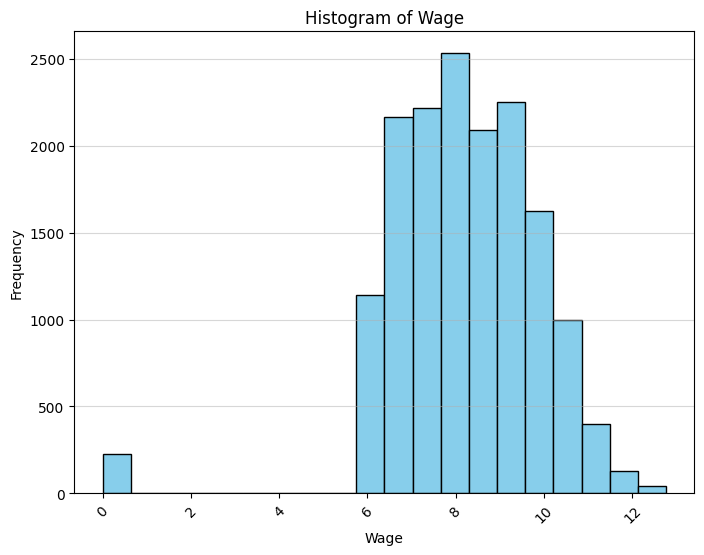

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(df['Wage'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Wage')
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)

# Rotate x-axis labels
plt.xticks(rotation=45)  # Adjust the rotation angle as needed

plt.show()

#### prepare data set for goal keepers only

In [18]:
df_goalkeeper = df.copy()

def clean_gk_column(string):
    html_string = '<span class="pos pos16">LM'

    # Define a regular expression pattern to match HTML tags
    html_tags_pattern = re.compile(r'<.*?>')

    # Use the sub() function to replace matched HTML tags with an empty string
    cleaned_string = html_tags_pattern.sub('', str(string))
    return cleaned_string

# clean Position column
df_goalkeeper['Position'] = df_goalkeeper['Position'].apply(clean_gk_column)
# select only goal keeper
df_goalkeeper = df_goalkeeper[df_goalkeeper['Position'] == 'GK']

# remove columns:
columns_to_keep_gk = ['Age','GKDiving', 'GKKicking', 'GKPositioning', 'GKReflexes','Reactions', 'Vision', 'Composure','LongPassing', 'Strength','Jumping', 'Overall']
df_goalkeeper = df_goalkeeper[columns_to_keep_gk]


# handle naivly NaN's
df_goalkeeper.loc[df_goalkeeper['Composure'].isna(), 'Composure'] = df_goalkeeper['Composure'].median()
df_goalkeeper.loc[df_goalkeeper['Jumping'].isna(), 'Jumping'] = df_goalkeeper['Jumping'].median()
df_goalkeeper.loc[df_goalkeeper['Vision'].isna(), 'Vision'] = df_goalkeeper['Vision'].median()

# store data frame
# df_goalkeeper.to_csv('../data/df_goalkeeper.csv', sep=',')
display(df_goalkeeper)

KeyError: 'Position'

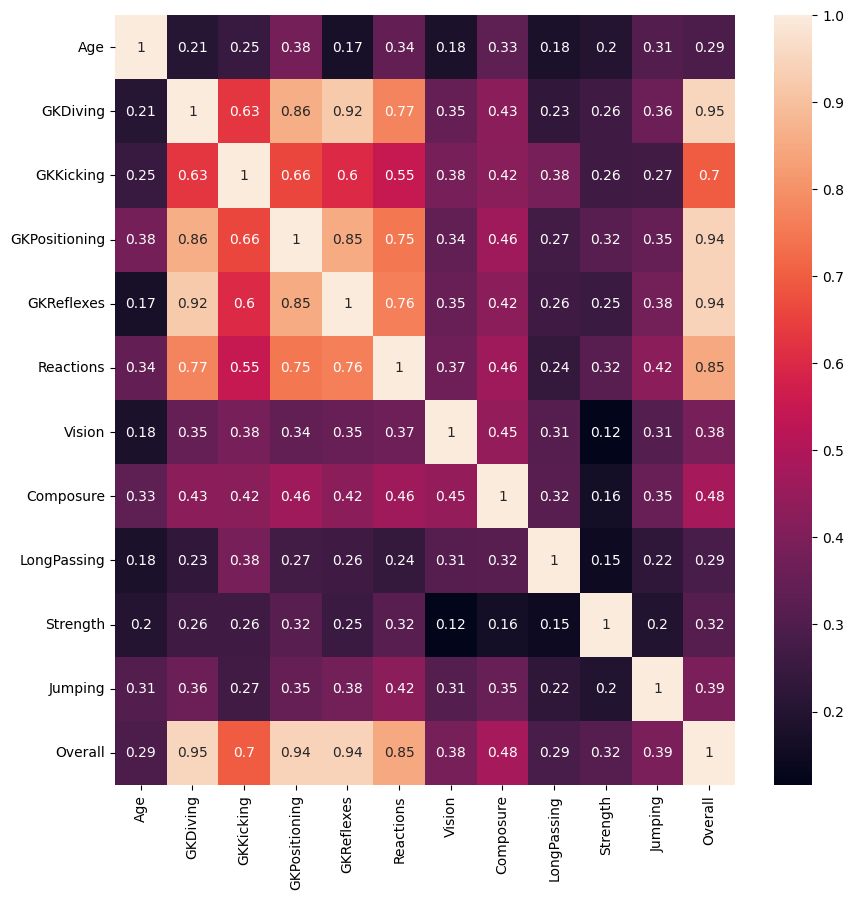

In [ ]:
corr_matrix = df_goalkeeper.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Min-max normalization

In [ ]:
df_goalkeeper_min_max = df_goalkeeper.copy()
# Min-max normalization function
def min_max_normalize(column):
    return (column - column.min()) / (column.max() - column.min())

columns_to_normalize = ['GKDiving','GKKicking','GKPositioning', 'GKReflexes','Reactions','Vision','Composure', 'LongPassing','Strength','Jumping','Overall']
df_goalkeeper_min_max[columns_to_normalize] = df_goalkeeper_min_max[columns_to_normalize].apply(min_max_normalize)

display(df_goalkeeper_min_max['Overall'])


10736    0.542857
11192    0.942857
12350    0.971429
13109    0.771429
13177    0.800000
           ...   
16604    0.085714
16651    0.085714
16661    0.000000
16670    0.085714
16678    0.057143
Name: Overall, Length: 572, dtype: float64

### Standard Scaler

In [ ]:
y = df_goalkeeper['Overall']
X = df_goalkeeper.drop('Overall', axis=1)

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale data X
scaler = StandardScaler()
columns_to_normalize = ['GKDiving','GKKicking','GKPositioning', 'GKReflexes','Reactions','Vision','Composure', 'LongPassing','Strength','Jumping','Overall']
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# df_goalkeeper[columns_to_normalize] = scaler.fit_transform(df_goalkeeper[columns_to_normalize])
display(X_train[0])

array([ 1.04161133,  0.94024898,  0.40854432,  0.72155064,  0.84107838,
        0.588591  ,  0.28146116, -0.41888778,  0.08899407,  0.36657316,
        0.24128566])

In [ ]:
# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error as an example evaluation metric
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.3972178967172238


In [ ]:
load_dotenv(find_dotenv())
api_key = os.getenv("PINECONE_API_KEY")
print(api_key)

d491de5e-ea31-492d-9faa-17bd98865332


In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# One-hot encode the target variable
one_hot_encoder = OneHotEncoder(sparse=False, categories='auto')
y_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Reshape the data for LSTM input (samples, time steps, features)
time_steps = 1  # We treat each sample as a single time step
X_train_lstm = X_train.reshape(X_train.shape[0], time_steps, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], time_steps, X_test.shape[1])

# Build the LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(time_steps, X_train.shape[1])))
model.add(Dense(3, activation='softmax'))  # Output layer with 3 classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_lstm, y_train, epochs=50, batch_size=8, validation_split=0.1)

# Evaluate the model on the test set
accuracy = model.evaluate(X_test_lstm, y_test)[1]
print("Test Accuracy:", accuracy)


/Users/alexanderlorenz/anaconda3/envs/ml/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
14/14 [==============================] - 3s 56ms/step - loss: 1.1261 - accuracy: 0.3148 - val_loss: 1.0865 - val_accuracy: 0.4167
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 1.0951 - accuracy: 0.3148 - val_loss: 1.0651 - val_accuracy: 0.4167
Epoch 3/50
14/14 [==============================] - 0s 5ms/step - loss: 1.0649 - accuracy: 0.3148 - val_loss: 1.0447 - val_accuracy: 0.4167
Epoch 4/50
14/14 [==============================] - 0s 6ms/step - loss: 1.0329 - accuracy: 0.3611 - val_loss: 1.0228 - val_accuracy: 0.5000
Epoch 5/50
14/14 [==============================] - 0s 6ms/step - loss: 1.0006 - accuracy: 0.6204 - val_loss: 0.9993 - val_accuracy: 0.5833
Epoch 6/50
14/14 [==============================] - 0s 5ms/step - loss: 0.9675 - accuracy: 0.6574 - val_loss: 0.9742 - val_accuracy: 0.5833
Epoch 7/50
14/14 [==============================] - 0s 6ms/step - loss: 0.9336 - accuracy: 0.6667 - val_loss: 0.9465 - val_accuracy: 0.5833
Epoch 8/50
14/14 [=